In [1]:
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch
import numpy as np
import sys
sys.path.append("BLIP")
from models.blip import BLIP_Base,load_checkpoint
import json

# Bag-of-Words Classifier

In [50]:
from functools import cache
from collections import deque
from math import log
from typing import Deque,Dict,List,Tuple
import nltk
import random
import string

class BOWClassifier:
    def __init__(self, classes=2, include_priors=True) -> None:
        self.classes = classes
        self.bow = [{} for i in range(classes)]
        self.all_words = set()

        self.tot = [0 for i in range(classes)]

        self.include_priors = include_priors

    def clean_text(self, text):
        return "".join([c for c in text if c not in string.punctuation and not c.isdigit()])

    def add_text(self, text, cls):
        text = self.clean_text(text)
        words = nltk.word_tokenize(text)
        for word in words:
            word = word.strip().lower()
            if word not in self.bow[cls]:
                self.bow[cls][word] = 0
            
            self.bow[cls][word]+=1
            self.tot[cls] += 1

            self.all_words.add(word)

    def classify(self, text):
        text = self.clean_text(text)
        words = nltk.word_tokenize(text)
        best = (-9999999999999999999, -1)
        for cls,bow in enumerate(self.bow):
            base_log_prob = 0
            if self.include_priors: base_log_prob += log(self.tot[cls]/sum(self.tot) + 1e-8)
            for word in self.all_words:
                freq = self.bow[cls][word]/self.tot[cls] if word in self.bow[cls] else 0
                base_log_prob += log(1.0001-freq)
            for word in words:
                word = word.strip().lower()
                freq = self.bow[cls][word]/self.tot[cls] if word in self.bow[cls] else 0
                base_log_prob -= log(1.0001-freq)
                base_log_prob += log(freq + 0.0001)
            best = max(best, (base_log_prob,cls))

        return best[1]

In [51]:
import pandas

df_dataset = pandas.read_csv("../datasets/olympics_2024/main_val_0.8_0.8.csv", delimiter="\t")
df_train = df_dataset[df_dataset["split"]=="train"]
df_valid = df_dataset[df_dataset["split"]=="valid"]

In [54]:
from tqdm import tqdm

def validate(tf_idf_knn):
    fp,fn,tp,tn = 0,0,0,0
    for idx, content in df_valid.iterrows():
        result = tf_idf_knn.classify(content["text"])
        if content["label"]==1 and result==1: tp += 1
        if content["label"]==1 and result==0: fn += 1
        if content["label"]==0 and result==1: fp += 1
        if content["label"]==0 and result==0: tn += 1
    return fp,fn,tp,tn

random.seed(42)

train = list(df_train.iterrows())
random.shuffle(train)

metric_history = []

classifier = BOWClassifier(include_priors=True)
for idx,(_,content) in tqdm(list(enumerate(train))):
    classifier.add_text(content["text"], content["label"])

    if idx > 0 and idx%10==0:
        metric_history.append((idx, validate(classifier)))

100%|██████████| 410/410 [00:03<00:00, 110.77it/s]


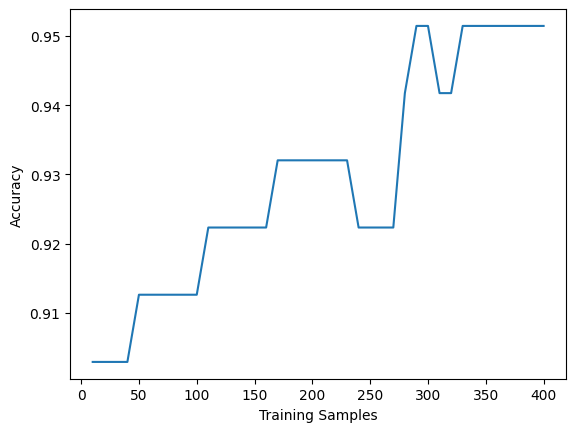

In [55]:
import matplotlib.pyplot as plt

plt.ylabel("Accuracy")
plt.xlabel("Training Samples")

plt.plot([metric[0] for metric in metric_history], [sum(metric[1][2:])/sum(metric[1]) for metric in metric_history])

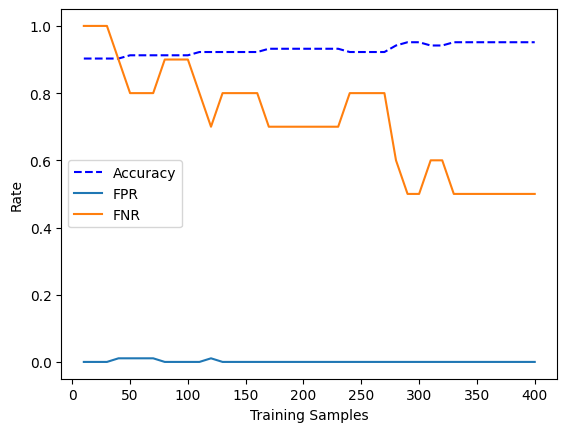

In [56]:
import matplotlib.pyplot as plt

plt.ylabel("Rate")
plt.xlabel("Training Samples")

plt.plot([metric[0] for metric in metric_history], [sum(metric[1][2:])/sum(metric[1]) for metric in metric_history], 'b--', label="Accuracy")
plt.plot([metric[0] for metric in metric_history], [metric[1][0]/(metric[1][0] + metric[1][3]) for metric in metric_history], label="FPR")
plt.plot([metric[0] for metric in metric_history], [metric[1][1]/(metric[1][1] + metric[1][2]) for metric in metric_history], label="FNR")
plt.legend()

In [57]:
metric_history

[(10, (0, 10, 0, 93)),
 (20, (0, 10, 0, 93)),
 (30, (0, 10, 0, 93)),
 (40, (1, 9, 1, 92)),
 (50, (1, 8, 2, 92)),
 (60, (1, 8, 2, 92)),
 (70, (1, 8, 2, 92)),
 (80, (0, 9, 1, 93)),
 (90, (0, 9, 1, 93)),
 (100, (0, 9, 1, 93)),
 (110, (0, 8, 2, 93)),
 (120, (1, 7, 3, 92)),
 (130, (0, 8, 2, 93)),
 (140, (0, 8, 2, 93)),
 (150, (0, 8, 2, 93)),
 (160, (0, 8, 2, 93)),
 (170, (0, 7, 3, 93)),
 (180, (0, 7, 3, 93)),
 (190, (0, 7, 3, 93)),
 (200, (0, 7, 3, 93)),
 (210, (0, 7, 3, 93)),
 (220, (0, 7, 3, 93)),
 (230, (0, 7, 3, 93)),
 (240, (0, 8, 2, 93)),
 (250, (0, 8, 2, 93)),
 (260, (0, 8, 2, 93)),
 (270, (0, 8, 2, 93)),
 (280, (0, 6, 4, 93)),
 (290, (0, 5, 5, 93)),
 (300, (0, 5, 5, 93)),
 (310, (0, 6, 4, 93)),
 (320, (0, 6, 4, 93)),
 (330, (0, 5, 5, 93)),
 (340, (0, 5, 5, 93)),
 (350, (0, 5, 5, 93)),
 (360, (0, 5, 5, 93)),
 (370, (0, 5, 5, 93)),
 (380, (0, 5, 5, 93)),
 (390, (0, 5, 5, 93)),
 (400, (0, 5, 5, 93))]

# BLIP Classifier

In [2]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

In [3]:
from RedditData import *

main_csv_path = "main_val_0.8_0.8.csv"

train_dataset = RedditDataset("../datasets/olympics_2024", main_csv=main_csv_path, im_transform=train_transform)
train_sampler = RedditDataSampler("../datasets/olympics_2024", main_csv=main_csv_path, upsampling=True)

val_dataset = RedditDataset("../datasets/olympics_2024", main_csv=main_csv_path, split="valid", im_transform=val_transform)
val_sampler = RedditDataSampler("../datasets/olympics_2024", main_csv=main_csv_path, split="valid")

train_dataloader = DataLoader(train_dataset, batch_sampler=BatchSampler(train_sampler, batch_size, True))
val_dataloader = DataLoader(val_dataset, batch_sampler=BatchSampler(val_sampler, 1, True))

In [4]:
from torch import nn
import torch
from torch.nn import CrossEntropyLoss
import sys
sys.path.append("BLIP")
from BLIP.models.blip import BLIP_Base,load_checkpoint
import json

class BLIPTextInjectEncoder(nn.Module):
    def __init__(self, pretrain_path="BLIP/blip_base.pth", med_config="BLIP/configs/med_config.json", device="cpu"):
        super().__init__()
        with open(med_config, "r") as f:
            self.config = json.load(f)

        self.encoder = BLIP_Base(image_size=224,vit="base",med_config=med_config)

        load_checkpoint(self.encoder, pretrain_path)
        self.encoder.eval()
        self.encoder = self.encoder.to(device)

        self.device = device
        self.text_inject = True

    def forward(self, image, text, has_image):
        with torch.no_grad():
            batches = len(image)
            image = image.to(self.device)
            image_embeds = self.encoder.visual_encoder(image) 

            # Tokenize text 
            if self.text_inject:  # Pad text to fit image embedding
                target_len = image_embeds.shape[1]
                fake = " ".join(["[PAD]"]*(target_len-2))
                text = tuple(list(text) + [fake])
                text = self.encoder.tokenizer(text, return_tensors="pt", padding="longest").to(self.device) 
                
                text_input_ids = text.input_ids[:batches]
                text_attention_mask = text.attention_mask[:batches]
            else:
                text = self.encoder.tokenizer(text, return_tensors="pt", padding="longest").to(self.device) 
                
                text_input_ids = text.input_ids
                text_attention_mask = text.attention_mask

            if self.text_inject:
                # substitute text embed for image embed
                text_embeds = self.encoder.text_encoder(text_input_ids, attention_mask = text_attention_mask,                      
                                                return_dict = True, mode = 'text')
                for i in range(len(image)): # Blank image
                    if not has_image[i]:
                        image_embeds[i] = text_embeds.last_hidden_state[i]

            # Get multimodal features
            image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(self.device)      
            
            text.input_ids[:,0] = self.encoder.tokenizer.enc_token_id
            output = self.encoder.text_encoder(text_input_ids,
                                        attention_mask = text_attention_mask,
                                        encoder_hidden_states = image_embeds,
                                        encoder_attention_mask = image_atts,      
                                        return_dict = True,
                                        )              
            hidden_state = output.last_hidden_state
            hidden_state = hidden_state[:,0,:].detach()
        return hidden_state
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = BLIPTextInjectEncoder(device=device)
device

load checkpoint from BLIP/blip_base.pth


device(type='cuda')

In [5]:
from sklearn.metrics import roc_curve,roc_auc_score

def get_metrics(yp, label, thresh=0.5):
    fp,fn,tp,tn=0,0,0,0
    roc = roc_curve(label, yp)
    roc_auc = roc_auc_score(label, yp)
    for y_pred,y_true in zip(yp, label):
        if y_pred < thresh and y_true >= thresh:  fn += 1
        if y_pred < thresh and y_true < thresh:   tn += 1
        if y_pred >= thresh and y_true >= thresh: tp += 1
        if y_pred >= thresh and y_true < thresh:  fp += 1
    return (fp,fn,tp,tn),roc,roc_auc

In [9]:
from tqdm import tqdm
classifier = nn.Sequential(
    nn.Linear(encoder.config["hidden_size"], 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.Sigmoid(),
).to(device)
loss = CrossEntropyLoss()
pbar = tqdm(train_dataloader, "Loss - ")
optimizer = torch.optim.Adam(classifier.parameters())
metric_history = []
for idx,data in enumerate(pbar):
    text,image,label,has_image = data
    image = image.float()

    label = F.one_hot(label, num_classes=2).float().to(device)
    
    yp = classifier(encoder(image, text, has_image))
    l = torch.mean(loss(yp, label))
    l.backward()
    optimizer.step()
    
    val_yp,val_yt = [],[]
    for item in val_dataloader:
        text,image,label,has_image = item
        image = image.float()
        image = image.float()

        label = F.one_hot(label, num_classes=2).float().to(device)
        with torch.no_grad():
            yp = classifier(encoder(image, text, has_image))
        yp = yp[:,1]/torch.sum(yp, dim=1)
        val_yp.append(yp.detach().cpu().numpy()[0])
        val_yt.append(label.detach().cpu().numpy()[0][1])
    metric_history.append(((idx+1)*batch_size, get_metrics(val_yp, val_yt)))

Loss - :  98%|█████████▊| 45/46 [07:32<00:10, 10.06s/it]


In [7]:
[metric[1][1] for metric in metric_history]

[(array([0.        , 0.01075269, 0.17204301, 0.17204301, 0.20430108,
         0.20430108, 0.22580645, 0.22580645, 0.27956989, 0.30107527,
         0.38709677, 0.38709677, 0.47311828, 0.47311828, 0.49462366,
         0.49462366, 0.51612903, 0.53763441, 0.53763441, 0.62365591,
         0.62365591, 0.70967742, 0.70967742, 0.80645161, 0.80645161,
         1.        ]),
  array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4,
         0.5, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1. , 1. ]),
  array([       inf, 0.4892052 , 0.4864343 , 0.4864053 , 0.48606974,
         0.48603916, 0.48593917, 0.48592368, 0.4857763 , 0.4857567 ,
         0.4849703 , 0.48490173, 0.48460183, 0.48453492, 0.4844887 ,
         0.48447657, 0.48439467, 0.4843286 , 0.48427907, 0.48396602,
         0.4839522 , 0.4835347 , 0.48346418, 0.48303103, 0.48297822,
         0.47960502], dtype=float32)),
 (array([0.        , 0.01075269, 0.06451613, 0.06451613, 0.11827957,
         0.11827957, 0.161290

In [44]:
idx = -1
fpr,tpr,thresh = metric_history[idx][1][1]

In [45]:
metric_history[idx][0]

736

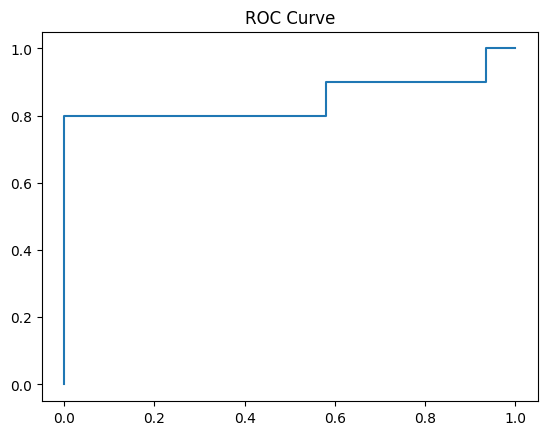

In [46]:
from matplotlib import pyplot as plt
plt.title("ROC Curve")
plt.plot(fpr,tpr)

In [10]:
fpr,tpr,thresh

(array([0.        , 0.        , 0.        , 0.1827957 , 0.20430108,
        0.22580645, 0.24731183, 0.58064516, 0.58064516, 0.93548387,
        0.93548387, 1.        ]),
 array([0. , 0.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 1. , 1. ]),
 array([       inf, 0.66449386, 0.57548267, 0.4718279 , 0.4707128 ,
        0.4656072 , 0.46536162, 0.4460759 , 0.44576323, 0.4233647 ,
        0.42290533, 0.4154468 ], dtype=float32))

In [12]:
metric_history

[(16,
  ((0, 10, 0, 93),
   (array([0.        , 0.01075269, 0.17204301, 0.17204301, 0.20430108,
           0.20430108, 0.22580645, 0.22580645, 0.27956989, 0.30107527,
           0.38709677, 0.38709677, 0.47311828, 0.47311828, 0.49462366,
           0.49462366, 0.51612903, 0.53763441, 0.53763441, 0.62365591,
           0.62365591, 0.70967742, 0.70967742, 0.80645161, 0.80645161,
           1.        ]),
    array([0. , 0. , 0. , 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4,
           0.5, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1. , 1. ]),
    array([       inf, 0.4892052 , 0.4864343 , 0.4864053 , 0.48606974,
           0.48603916, 0.48593917, 0.48592368, 0.4857763 , 0.4857567 ,
           0.4849703 , 0.48490173, 0.48460183, 0.48453492, 0.4844887 ,
           0.48447657, 0.48439467, 0.4843286 , 0.48427907, 0.48396602,
           0.4839522 , 0.4835347 , 0.48346418, 0.48303103, 0.48297822,
           0.47960502], dtype=float32)),
   0.5365591397849463)),
 (32,
  ((0, 10, 0, 

# Ensembled BLIP + BoW

In [58]:
from typing import Tuple,List


class BLIPOnlineEnsemble:
    def __init__(self, pretrain_path="BLIP/blip_base.pth", med_config="BLIP/configs/med_config.json", n: int=1, bootstrap_size: float = 0.8, device="cpu"):
        self.encoder = BLIPTextInjectEncoder(pretrain_path=pretrain_path, med_config=med_config)
        self.cls_heads: List[nn.Sequential] = [
            nn.Sequential(
                nn.Linear(self.encoder.config["hidden_size"], 10),
                nn.ReLU(),
                nn.Linear(10, 2),
                nn.Sigmoid(),
            ) 
            for _ in range(n)]
        
        

        self.n: int = n

    def __call__(self, text: str, image: np.array|None = None) -> Tuple[int, int]: # Return positive and negative votes
        pass

    def train(self, text: List[str], image: torch.Tensor, has_image: torch.Tensor, yt: torch.Tensor):
        blip_features = self.encoder(image, text, has_image)
        

IndentationError: expected an indented block after class definition on line 1 (3466084336.py, line 1)